*Note:* This topic is different from my original proposed topic of using reinforcement learning to teach a machiene to play the first level of Super Mario Bros. This unfortunetly was not multi GPU parallelizable, and since the default code already has GPU support there would have been no parallelization done by me. However, this does not mean I did not get the code to work. Please see `./MariOh/README.md` for more information and instructions on how to make the HPCC play Mario and watch it while it does!

# Part 2 - PyTorch Classifier with Convolutional Neural Network

By "Brandon McIntyre"

 <img src="https://developers.google.com/machine-learning/practica/image-classification/images/cnn_architecture.svg" alt="Just a simple camera icon intended to be replaced with your image" width="100%">

Image from: https://developers.google.com/machine-learning/practica/image-classification/images/cnn_architecture.svg

---
# Abstract

**Domain**  

Convolution Neural Networks (CNN) are apart of a greater class of learning called "Deep Learning". Deep learning is a type of learning, or computational model more specificially, that invloves creating what is known as an artifical neural network (ANN). An ANN is pretty much a bunch of perceptrons stringed together by weights, often in what are known as "layers". A perceptron is meant to abstractly mimic a neuron in the brain (which has action potiental and only fires when it passes a threshold) and ouputs a value based on the weights and values sent to it. In our case this creates the unique oppurtunity where the perceptrons can work as a system to guess at what the input image was and make guess at what class that image belongs to. This takes the approach of trail and error and learning, versus just searching all possible search spaces. This gives it the ability to guess quickly and slowly correct itself as it tries to guess the right image and will slowly "learn". There is obviously much more to NN, but it is a facinating bridge between computer science and cognitive science. What makes a CNN important to a classifier, is a CNN has an added special ability to recognize patterns, which makes it quite useful for pattern recognition in photos. This area has important implications in computer vision. It can allow automatic detection of objects in photographs making it useful for real life object detection and searching efforts when there is no human to make the judgement call.

**Motivation**

My interest in this space is really what drove me to where I am now here at MSU. This idea that we can create machines/programs that can learn the enviroment is really quite fascinating. The fact we can create things that are artifically intelligent and could almost seem conscious is really one of the most bizzare things out there. That fascination has led me to learning Data Science and becoming interested in Cognitive Science and all the ways we can use computation to accomplish the feats that at one time only seemed a human could do. Quite honestly, this field of study has fundamentally changed the way I look at life, and studying CNN and PyTorch just seems like a natural extension of my fascinations now.  

**Computation in Convolution Neural Networks**

In order for a Convolutional Neural Network to work and learn, there is a ton of computation and calculations that need to be done. An ANN is really just a bunch of linear algebra that can spit out a result. The base of the NN is just a bunch of perceptrons, that are really just functions that take in a bunch of signals and add them together. These functions can be many things like a sigmoid function, or RELU, etc. The function acts acts as a way the perceptron can pass different signal strengths to the next perceptron. It is this signal passing between perceptrons that allows us takes an input into our NN and pump out a result based on that input. This is just merely the guess of the NN as usually the end "layer" of the NN has a perceptron for each guess our NN can make. The learning comes from what is known as the "forward" and "backward" algorithm. Again just fancy linear algebra, that adjusts the weights of the NN to change the strength of signals between perceptrons. So with all calculations comes computation. This computation, however, is parallelizable as often most of the calculations can be teased apart and easily mapped to a GPU. Since a GPU is just a bunch of very tiny cores, it is perfect to perform a bunch of very simple calculations and summing. In the case of the of our CNN, the image will be teased apart into pixels, some transformations will happen, and then each pixel will be mapped to a perceptron in the ANN and then we will need to calculate the signal passing between every single perceptron. The signals with then be passed to the last layer and the guess at the classification of the image will then be avalible. Then, if training, we will use that guess and the real answer to go back through the neural network and correct the weights so that next time if that input was to be passed in, it has a better chance of guessing the correct answer. This is simplisitically what we will be doing with our model.

**Timing Study**

In this project we ask the question of does parellelizing this CNN code with multiple GPUs (`Tesla K80` GPU specifically) speed up the code. We find that using a GPU really does speed up this code and is well worth the process of adding GPU support. However, along the way we stumble upon an interesting question of what about the case of using multiple GPU? It appears that question seems to be a question of what is the batch size. We see that a single GPU will perform better than multiple GPU with a small enough batch size. We also see the limitations of the studies that were done, and future questions to be explored.


---
# Methodology

The CNN classifier is created using a basic CNN structure and the CNN is trained and tested on the [CIFAR10 dataset](https://www.tensorflow.org/datasets/catalog/cifar10). The code for this comes directly from PyTorch's website tutorials [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py). The code provided is serial utilizing only a CPU. My task was to parallelize first with GPU support and then parallelize with mutliple GPU support. Fortuntely with pytorch this is a pretty painless process.

In order to run the code, it is advised to visit [`./pytorch_classifier/README.md`](./pytorch_classifier/README.md). In that README file you will find everything that is needed to setup an enviroment on the HPCC that can run this python code. In sort, the README file will tell you how to install Anaconda 3 with python 3.8 on the HPCC, walk you through how to set up the appropiate enviroment using `.yml` file, and make sure you can activate the `pytorch_classifier` enviroment. This will be imperative to getting any of the following code working.

I made many modifications to make this code easy to work with my submission script, but I will go over the main modifications I made to the original code to Parallalelize it with single GPU and then mutli GPU support.

## Single GPU Parallelize

At the beginning of the code (Part 1 of Tutorial) I added the following line
```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```
This allows PyTorch to check if a GPU is avaliable, and if not it will set this device varaible to CPU.

Then after defining the network as a class called `Net` (Part 2 of Tutorial), the code instantiates `Net` and saves this with a Variable `net`.
```python
net = Net()
```
Here is the first of the modification we will make to send the code to the GPU. Luckily this is really easy with PyTorch, all we have to do is add `.to(device)` to our code to accomplish the sending to the GPU.
```python
net = Net().to(device)
```

The next change we have to make is inside of the main epcoh loop (Part 4 of the Tutorial). This will be to our data, as we will need to both the inputs and labels to the GPU for training.
```python
# Original serial verison
inputs, labels = data

# GPU support version
inputs, labels = data[0].to(device), data[1].to(device)
```

*Note: In the Tutorial in Part 5. It has code the essentially reloads the model from the saved model. This was noted as not necessary, and I did not include that in the code I ran because it is not needed for this model (and make our job harder)

When testing our CNN we will need to apply similar changes to send data to the GPU. The first part is when we are only testing a few images (Beginning of Part 5 of tutorial). We will need to grab the few images we are testing and send that to the GPU.
```python
# Original serial version
dataiter = iter(testloader)
images, labels = dataiter.next()

# GPU support version
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
```

The second part, a naturally extension of the first part, is testing with all images (Middle of Part 5). This is located in the first for-loop that loops through all of the data. We simply just need to send the data to the GPU again with the following code (that we also used above).
```python
# Original serial version
images, labels = data

# GPU support version
inputs, labels = data[0].to(device), data[1].to(device)
```

Finally, using the same exact process as the second step, but now in the second for-loop looping through all the data that is now checking for accuracy per classification  group (End of Part 5 in tutorial)
```python
# Original serial version
images, labels = data

# GPU support version
inputs, labels = data[0].to(device), data[1].to(device)
```

Following the above steps will create code that is parallelized with 1 GPU. Now to multiple GPUs (which is even easier)

## Multi GPU Parallelize

With PyTorch this really could not be any easier. The following will parallelize the code with multi GPU support.

There is, in fact, only one change that needs to be made to make this work on multiple GPUs. This occurs when we first instantiate our `Net` class. We simply will just want to pass in our `Net` instantiation into `nn.DataParallel()`. This can be see by the following
```python
# Single GPU support version
net = Net().to(device)

# Multiple GPU support version
net = Net()
if gpu_avail > 1:
    net = nn.DataParallel(net)
net = net.to(device)
```
What this code does is break apart the instantiation to allow us to pass in `net` into `nn.DataParallel()` only if more than one is GPU is avaliable. Then just like before we send the network to the "device". Fortunetly enough, `nn.DataParallel()` is smart enough that it will now handle everying dealing with more than 1 GPU. Even though `device` just refers to cuda, the network will send the right data to the right GPUs.

Now we have created code that can actually run in serial if no GPU's are avalible, run with 1 GPU if only one is available, or run with mutliple GPU if multiple GPUs are availiable.

## Alterations to code for timing study

The timing study I conducted was to see how the time it took to run the model changed across computation types (CPU only, single GPU, multiple GPU) and batch sizes. The accuracy was also recorded and analyzed. The hope was to see if multiple GPU parallelization provides speed up over CPU and single GPU models, and how much changing batch affected time and accuracy.

I will not go too deeply into my code alterations for the timing study as they could be implemented many ways, but I will give a general breakdown of what I did.

* Created new python file called `data_load.py` that contains the first couple of lines that download and load the data. I did this because I included this at the beginning of the submissions scripts. So in case if the data was not downloaded, that time of downloading was not included in the timed portion of the test.
* Created a way to pass in argument while running script from command line that can change the batch size of the model. I ran my model with 5 different batch sizes `50`,`100`,`150`,`200`,`250` to compare time it took to run model
* Altered the dimensions of the CNN in `Net` at the suggestion of the tutorial (found at the end of tutorial). I changed the fist Conv2d to `nn.Conv2d(3, 64, 5)` and the second Conv2d to `self.conv2 = nn.Conv2d(64, 16, 5)`
> **For reference:** Exercise: Try increasing the width of your network (argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number), see what kind of speedup you get
* Changed the number of epochs to `20` with a variable. (If wanted could also make that an argument to pass in).
* Finally, I created three different codes for ease of alteration. With each code I changed the output files to be saved in a `output` folder. I also changed the label of all of the outputs to also include the batch size and compute type (`CPU`,`single`,`multi`)

## Running the provided code

You can run a test of the provided pre-modified code plus submission scripts with a few simple make commands. Each code will run for 20 epochs with a batch size of 250 (should take about 4 min for each). To run the multiple GPU code, make sure you are on a dev node with GPU access that is not `dev-intel14-k20`.

**NOTE: Make sure you have the appropiate enviroment activated and installed. See [`./pytorch_classifier/README.md`](./pytorch_classifier/README.md) on how to set up your Anaconda `pytorch_classifier` enviroment. It is imperative this enviroment is used prior to running these cells**

CPU only code

In [ ]:
!cd ./timing_study && make -i clean
!cd ./timing_study && make cpu

Single GPU code

In [ ]:
!cd ./timing_study && make -i clean
!cd ./timing_study && make single

Multiple GPU code

In [ ]:
!cd ./timing_study && make -i clean
!cd ./timing_study && make multi

If on the HPCC you can submit the submission scripts with the following code

In [ ]:
!cd ./timing_study && make -i clean
!cd ./timing_study && sbatch cpu_classifier.sb
!cd ./timing_study && sbatch single_classifier.sb
!cd ./timing_study && sbatch multi_classifier.sb

## Conducting Timing Study

To conduct the timing study I utilized the `cpu_classifier.py`,`single_classifier.py`, and `multi_classifier.py` code provided in `./timing_study`. Specifically, I ran the code using the HPCC job scheudler with the `cpu_classifier.sb`,`single_classifier.sb`, and `multi_classifier.sb` submission scripts. With the submission scripts I specifically used the `Tesla k80` GPUs. This is becuase I wanted to make sure the `Tesla k20` GPUs were not used, because these are incompatible with the PyTorch Cuda code.

The study varied 2 things; the model (CPU only, Single GPU, and Multiple GPU) and batch size. The idea behind this is because of the overhead of using mutltiple GPUs was noticed to make the multiple GPU code run slower than the single GPU code at lower batch sizes. However, as batch size increased the multiple GPU was faster. So in the submission scripts I did just that. I made the batch size changeable for each code and timed how long it took for that code to run 10 times at that given batch size. 

In order to make the timing fair between studies make sure that the data is downloaded before conducting the timing studies, this way there is no run of code that is thrown off by the one-time data download.

For my specific tests, I used batch sizes (50, 100, 150, 200, 250), I used computational types CPU only, Single `K80` GPU, and 4 `K80` GPUs, I also ran each code for 20 epochs, and finally I ran each code 10 times at its given batch size to find the average time it took. I also collected the accuracy of each run and averaged that to obatined an average accuracy of the batch size. 

---
# Timing Results

&#9989;  Show the results of a baseline experiment on a single core and after optimization.  Also include a graph of the results. 


&#9989;  Provide the results of a benchmark or scaling study for your project.  Make sure you include a description of the hardware that was used and graph the results.  Make sure you include detailed descriptions about the hardware that was used.  Graphs alone are not sufficient, explain the graphs. Did they meet expectations?  Was there any anomalies?

The timing study I conducted was to see how the time it took to train 20 epochs changed across computation types (CPU only, single GPU, multiple GPU) and batch sizes. The accuracy of each batch size was also recorded to show the effects batch size has on accuracy.

The hardware that was used for this timing study was the HPCC. More specifically, the timing study was done doing the job scheduler and the `Tesla k80` GPUs. Each timing study was submitted and ran as a job since the time to record 10 runs of each took multiple hours. For each example only 1 node and 1 core was avaliable.

## CPU

To start off we have our serial code that runs only on the CPU. This of course had the worst performance of all. Below we can see the time it took per batch size. Also we can see the accuracy across each batch size. 

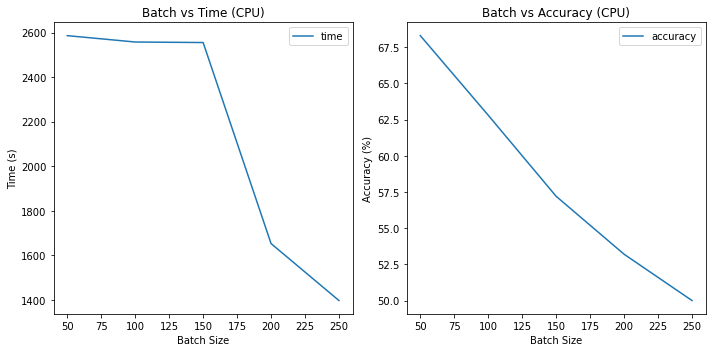

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Load in data
cpu = pd.read_csv("./results/cpu.txt")

figure, axes = plt.subplots(1,2, figsize=(10,5))
cpu.plot("batch","time",ax=axes[0])
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Time (s)")
axes[0].set_title("Batch vs Time (CPU)")

cpu.plot("batch","accuracy",ax=axes[1])
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Batch vs Accuracy (CPU)")

plt.tight_layout()

From above we can see that with a batch size from 50 to 150 the time it took decreased only a little, however, between batch sizes 150 and 200 there was a tremendous drop between 2500 sec to 1600 sec. Almost 1000 sec or so. That is really 

## Single GPU

The following are the results for the same procedure excpet using a single `Tesla K80` GPU. As well, I have plotted to effects on accuracy by batch size.

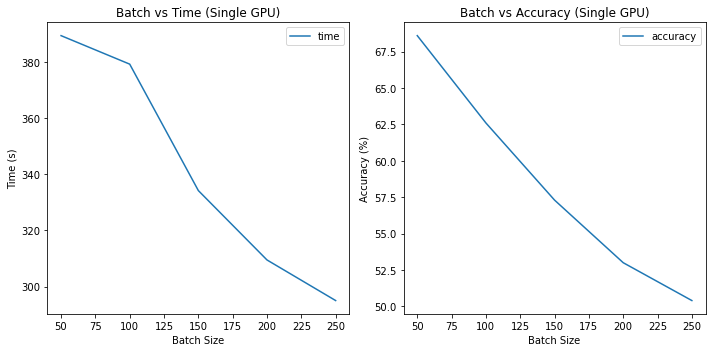

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Load in data
single = pd.read_csv("./results/single.txt")

figure, axes = plt.subplots(1,2, figsize=(10,5))
single.plot("batch","time",ax=axes[0])
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Time (s)")
axes[0].set_title("Batch vs Time (Single GPU)")

single.plot("batch","accuracy",ax=axes[1])
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Batch vs Accuracy (Single GPU)")

plt.tight_layout()

As we can see from above as the batch size increased the time decreased by quite much (around 100 seconds from small to large batch size). This for sure beat out the CPU times as this was done in matter of few minutes versus the 40 minuetes the CPU only version took. I think this really shows how using a GPU is a must for this type of problem, becuase the speed up alone between the CPU and this GPU version is quite tremendous.

## Multiple GPUs

The following are the results for the same procedure except using a 4 Tesla K80 GPUs. As well, I have plotted to effects on accuracy by batch size.

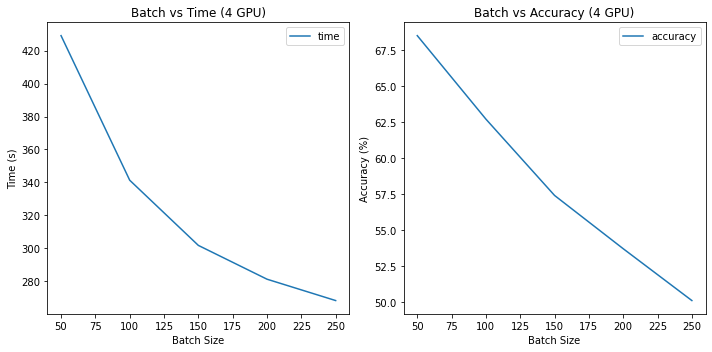

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Load in data
multi = pd.read_csv("./results/multi_4.txt")

figure, axes = plt.subplots(1,2, figsize=(10,5))
multi.plot("batch","time",ax=axes[0])
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Time (s)")
axes[0].set_title("Batch vs Time (4 GPU)")

multi.plot("batch","accuracy",ax=axes[1])
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Batch vs Accuracy (4 GPU)")

plt.tight_layout()

Just like we found with single GPU, as batch size increases the time decreases. Also just as batch sizes increase the accuracy decreases. Both of these make sense and make sense that we see similar results with just using 1 GPU.

## Single GPU vs Multiple GPU

Now since obviously the CPU ran much much slower, we know using a GPU for the calculations is really the way to go. However, the question really is do we need single or mutliple GPUs? In order to look further into this, here is the two plots of the single GPU and mutliple GPUs of time vs batch size plotted together.

Text(0.5, 1.0, 'Batch vs Time')

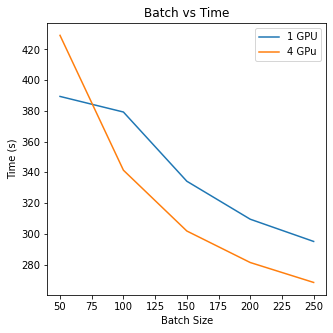

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Load in data
single = pd.read_csv("./results/single.txt")
multi = pd.read_csv("./results/multi_4.txt")

figure, axes = plt.subplots(1,1, figsize=(5,5))
single.plot("batch","time",ax=axes, label="1 GPU")
multi.plot("batch","time",ax=axes, label="4 GPU")
axes.set_xlabel("Batch Size")
axes.set_ylabel("Time (s)")
axes.set_title("Batch vs Time")


Something interesting we can see here is that when the batch size is at 50, it appears that the single GPU is faster than the 4 GPUs. However, at a batch size of 100, the roles reverse and multiple GPU is faster and this continues on till the end of graph. Also something interesting is that the difference in time between the two remains almost consitent. After batch size of 100 the time curve has the same shape. They both look like they are beginning to plateu. It could be interesting to see as the batch size increased if they would flatten out and if that time difference remained constant or if that pattern only holds for the batch sizes we have here. But this plot really does show that using 4 GPUs can speed up this process past a certain threshold of batch size. 

Something now that naturally crosses the mind is what happens with different number of GPU? I think doing this timing study has opened the door for more questions, and further research needs to be done to see how effective using multiple GPU can be and also begs the question of when does it make sense to use Mutlitple GPU and can too many be overkill?

---
# Concluding Discussion and Future Work


This project was focused on Parallelizing a CNN classifier on the CIFAR 10 dataset. The goal was to see what kind of speeds up we could have on 20 epochs of the classifier at different batch sizes with a CPU, 1 GPU, and 4 GPU. I found that using a GPU really does speed up this code and is well worth the process of adding GPU support. However, along the way I stumbled upon an interesting question of what about the case of using multiple GPU? It appears that question seems to be a question of what is the batch size. It also opened up many more questions of the realtionship in time using mutliple GPUs have and even the realtionship of batch size and accuracy. The question of using mutliple GPU seems to be a mutli-facted question that requires more information.

This project was great becuase I got hands on experince of learning what and what cannot be mutliple GPU parallelized. I learned that the deciding factor can be the batch size, and sometimes using more than one GPU does not make sense in some sitation where just 1 GPU would suffice. I also learned that really this all a balance. The higher the batch size, the more parallelizable, but the less the average accuracy so really the more epochs that will need to be run. I think exploring this further it would be interesting to see how many more epochs past 20 would be needed to achieve the same accuracy scores with the lower batch sizes.

I can think of two routes we could go from here that could be interesting.  

The first is playing around more with the number of GPUs. As we see from the last section there seems to be a realtionship between batch size and number of GPU and a threshold at which a certain number of GPU are better. It would be really interesting to explore this further and see what would happen at 2, 3, 5, 6, 7, and 8 GPU and if they all follow that some curve and where those threshold points are if that are all at the same number of batch size or different batch sizes. It also be interesting to further explore the intersection of the batch sizes, accuracy, and number of GPUs. To maybe even see if we could optimize our time, number of GPUs, and our accuracy. This could really nail down the question of where does paralleizing make sense, and how big should we go in terms of batch sizes and does this make sence with the number of epochs we need to run.

The other route could be to turn this problem into a hybird problem. This could be done by using `nn.parallel.DistributedDataParallel` instead of `nn.DataParallel`. This would allow us to create a MPI and CUDA hybrid which is said to increase performance even in the case of a single node and GPU. I did not have time to try this option but it could be interesting to see what further speed ups there could be. This way is a little more intensive as you will have to set up the MPI with the sperate function `torch.distributed.init_process_group`.

---
# References  

PyTorch Website for alot of small things and documentation on functions:  
https://pytorch.org/

Convolutional Neural Networks:  
https://www.youtube.com/watch?v=YRhxdVk_sIs

Parallelizing CNN:  
https://core.ac.uk/download/pdf/229563237.pdf

Conda Enviroments:  
https://towardsdatascience.com/a-guide-to-conda-environments-bc6180fc533#e814  
https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#removing-an-environment  

Further steps:  
https://pytorch.org/docs/stable/distributed.html#torch.distributed.init_process_group

MariOh References: (Not apart of this Part)  
https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html  

----